In [1]:
import warnings
warnings.filterwarnings('ignore')

from acv_explainers import ACVTree
import shap

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRFClassifier, XGBClassifier, XGBRegressor
from sklearn.metrics import roc_auc_score
import random 
import time 
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import comb

random.seed(2021)
np.random.seed(2021)

from experiments.exp_linear import *

# Fixed the seed and plot env
random.seed(1)
np.random.seed(1)

# plt.style.use(['ggplot'])

In [3]:
# values of the correlation coefficient p \in (0, 1)
p_space = np.linspace(0, 0.99, 30)
p_space

array([0.        , 0.03413793, 0.06827586, 0.10241379, 0.13655172,
       0.17068966, 0.20482759, 0.23896552, 0.27310345, 0.30724138,
       0.34137931, 0.37551724, 0.40965517, 0.4437931 , 0.47793103,
       0.51206897, 0.5462069 , 0.58034483, 0.61448276, 0.64862069,
       0.68275862, 0.71689655, 0.75103448, 0.78517241, 0.81931034,
       0.85344828, 0.88758621, 0.92172414, 0.95586207, 0.99      ])

## Compute Estimation w.r.t Dependence

In [4]:
p_space = np.linspace(0, 0.99, 30)
shap_errors = []
leaf_errors = []
for p in p_space:
    n = 10000
    d = 5
    mean = np.zeros(d)

    cov = p*np.ones(shape=(d, d)) - (p - 1)*np.eye(d)
    C = [[]]

#     coefs = 4*np.random.randn(d)
    coefs = np.ones(d)
    model_type = 'linear'
    k = 10
    coefs[k:] = 0

    exp = ExperimentsLinear(mean=mean, cov=cov, coefs=coefs, n=n, C=C)
    data = exp.data

#     print('Coefficients of the Linear regression are = {}'.format(coefs))

    model = RandomForestRegressor(n_estimators=1, max_depth=6)
    model.fit(exp.data, exp.y_train)

#     print('TEST SET MSE = {}'.format(mean_squared_error(model.predict(exp.data_test), exp.y_test)))

    ## Build ACVTREE

    acvtree = ACVTree(model, data)

    n_gen = 50000
    nb = 100
    exp2 = ExperimentsLinear(mean=mean, cov=cov, coefs=coefs, n=n_gen, C=C)
    data_gen = np.array(exp.data, dtype=np.float)

    plug_sv = acvtree.py_shap_values_notoptimized(data_gen[:nb], C=[[]], data=data)
    mc_sv = tree_sv_exact(data_gen[:nb], C=[[]], tree=acvtree, mean=mean, cov=cov, N=1000)
    
    # shap_sv = tree_shap(X=data_gen[:nb], data=data, C=[[]], tree=acvtree, value_function=shap_cond_exp)
    explainer_observational = shap.TreeExplainer(model, feature_perturbation='observational')
    shap_sv = explainer_observational.shap_values(data_gen[:nb])
    
    
    plug_sv = plug_sv.squeeze()
    shap_sv = shap_sv.squeeze()
    mc_sv = mc_sv.squeeze()
    
    
    relative = np.zeros(shape=mc_sv.shape)
    for i in range(mc_sv.shape[0]):
        for j in range(mc_sv.shape[1]):
            if np.abs(mc_sv[i, j]) <= 1:
                relative[i, j] = 1
            else:
                relative[i, j] = mc_sv[i, j]

    err_monte_carlo = l1_norm(mc_sv- mc_sv)
    err_plugin = l1_norm((plug_sv - mc_sv)/relative)
    err_shap = l1_norm((shap_sv - mc_sv)/relative)
    err_concat = np.concatenate([err_shap, err_plugin], axis=0)
    
    shap_errors.append(np.mean(err_shap))
    leaf_errors.append(np.mean(err_plugin))

100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


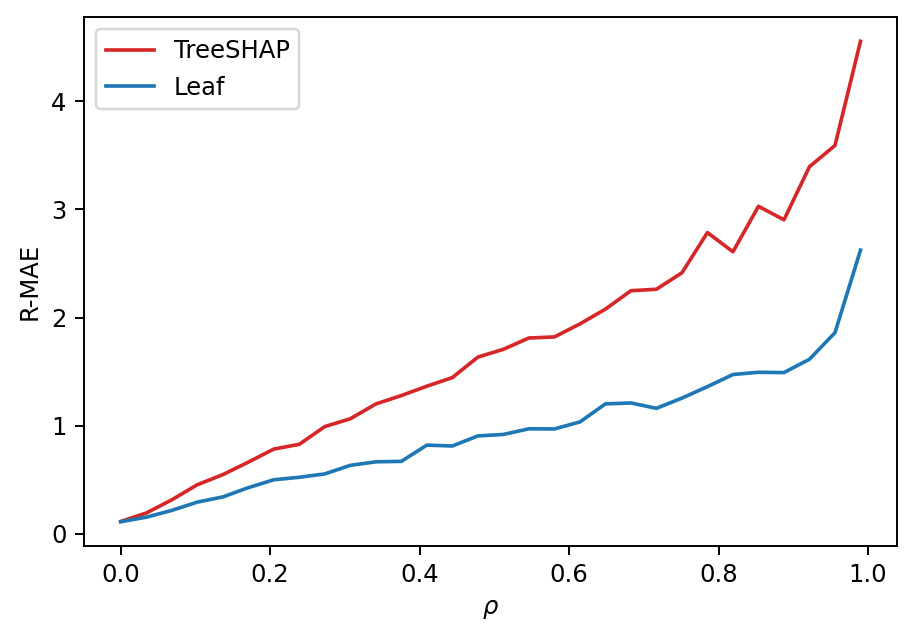

In [5]:
plt.figure(dpi=175)
plt.plot(p_space, shap_errors, label='TreeSHAP', color=sns.color_palette()[3])
plt.plot(p_space, leaf_errors, label='Leaf', color=sns.color_palette()[0])
plt.xlabel(r'$\rho$')
plt.ylabel('R-MAE')
plt.legend()